<a href="https://colab.research.google.com/github/malraharsh/temp2/blob/master/Skin_Disease_Classifier_Repos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
!mkdir -p dataset train test

In [5]:
# from google.colab import drive
# # drive.mount('/content/drive', force_remount=True)
# drive.mount('/content/drive')

In [6]:
!mkdir -p "/content/drive/My Drive/ham10000"
%cd "/content/drive/My Drive/ham10000"

/content/drive/My Drive/ham10000


In [7]:
%%bash

DATASET_DIR="/content/dataset/"

if [ ! -f "HAM10000_images_part_1.zip" ]; then
    echo "Downloading HAM10000_images_part_1.zip ..."
    wget --show-progress --progress=bar:force https://dataverse.harvard.edu/api/access/datafile/3172585 -O HAM10000_images_part_1.zip
fi

echo "Unpacking HAM10000_images_part_1.zip ..."
unzip -q HAM10000_images_part_1.zip -d $DATASET_DIR

Unpacking HAM10000_images_part_1.zip ...


In [8]:
%%bash

DATASET_DIR="/content/dataset/"

if [ ! -f "HAM10000_images_part_2.zip" ]; then
    echo "Downloading HAM10000_images_part_2.zip ..."
    wget --show-progress --progress=bar:force https://dataverse.harvard.edu/api/access/datafile/3172584 -O HAM10000_images_part_2.zip
fi

echo "Unpacking HAM10000_images_part_2.zip ..."
unzip -q HAM10000_images_part_2.zip -d $DATASET_DIR

Unpacking HAM10000_images_part_2.zip ...


In [9]:
%%bash

DATASET_DIR="/content/dataset/"

if [ -d $DATASET_DIR ] && [ $(ls -1 $DATASET_DIR | wc -l) -eq 10015 ]; then
    echo "Successfully built the dataset"
else
    echo "Error when building the dataset"
fi

Successfully built the dataset


In [10]:
%cd /content

/content


In [11]:
%%bash

if [ ! -f "HAM10000_metadata.csv" ]; then
    echo "Downloading HAM10000_metadata.csv"
    wget --show-progress --progress=bar:force https://dataverse.harvard.edu/api/access/datafile/3172582?format=original -O HAM10000_metadata.csv
fi

--2021-02-05 06:52:23--  https://dataverse.harvard.edu/api/access/datafile/3172582?format=original
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 206.191.184.198
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|206.191.184.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 563277 (550K) [text/csv]
Saving to: ‘HAM10000_metadata.csv’

HAM10000_metadata.c 100%[===================>] 550.08K  1.60MB/s    in 0.3s    

2021-02-05 06:52:24 (1.60 MB/s) - ‘HAM10000_metadata.csv’ saved [563277/563277]



In [12]:
path_data = '/content/dataset' #os.getcwd() + "/HAM10000"
path_metadata = '/content/HAM10000_metadata.csv'

df_data = pd.read_csv(path_metadata)

In [13]:
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [14]:
# %mkdir destination
path_dest = '/content/destination'

In [15]:
labels = list(set(df_data['dx']))
# labels = ['akiec', 'vasc', 'df', 'nv', 'bkl', 'bcc']

In [16]:
import shutil

In [17]:
path_root = '/content/'

In [18]:
df_train, df_val = train_test_split(df_data, test_size=0.1,
                                    random_state=101, 
                                    stratify=df_data['dx'])

In [19]:
path_train = path_root + 'train'
path_test = path_root + 'test'

In [20]:
def show_label(images, label, path):
    r, c = 1, 5
    plt.figure(figsize=(15, 12))
    # plt.suptitle(label, fontsize=30)
    for pos, img in enumerate(images[:r*c]):
        plt.subplot(r, c, pos+1)
        img = plt.imread(path + img + '.jpg')
        plt.imshow(img)
        plt.axis('off')
    plt.show()

Moving Train Images
/content/train/akiec/


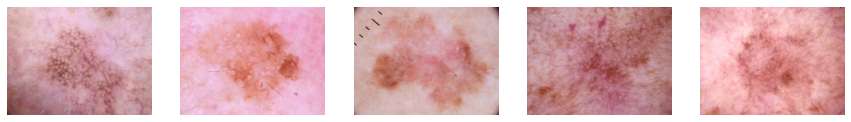

Shifted AKIEC - 294
/content/train/bkl/


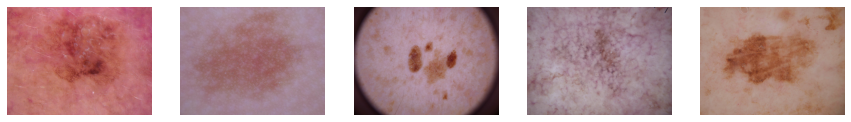

Shifted BKL - 989
/content/train/vasc/


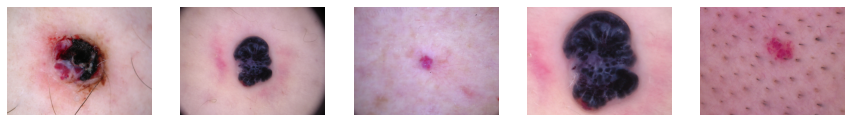

Shifted VASC - 128
/content/train/mel/


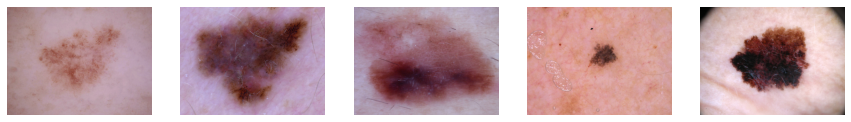

Shifted MEL - 1002
/content/train/bcc/


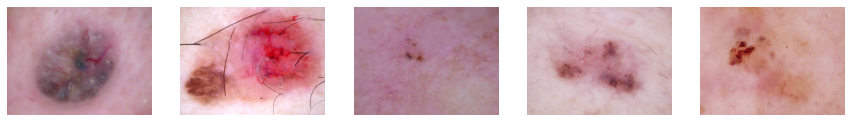

Shifted BCC - 463
/content/train/nv/


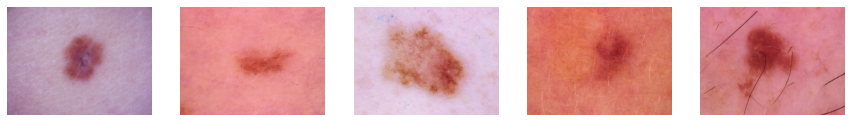

Shifted NV - 6034
/content/train/df/


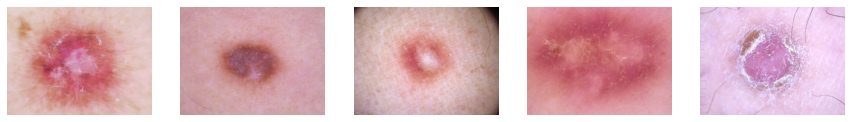

Shifted DF - 103
Moving Test Images
/content/test/akiec/


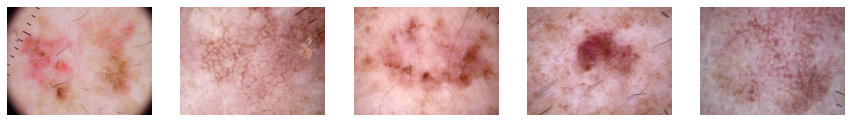

Shifted AKIEC - 33
/content/test/bkl/


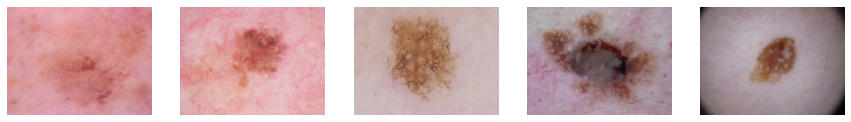

Shifted BKL - 110
/content/test/vasc/


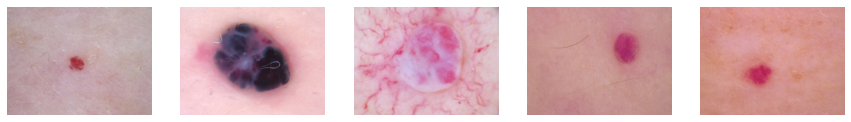

Shifted VASC - 14
/content/test/mel/


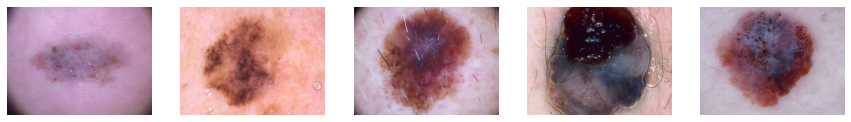

Shifted MEL - 111
/content/test/bcc/


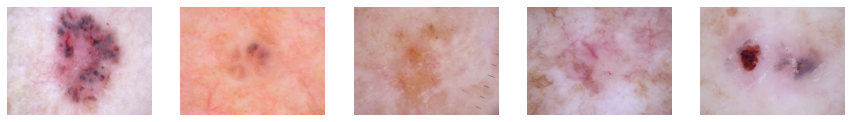

Shifted BCC - 51
/content/test/nv/


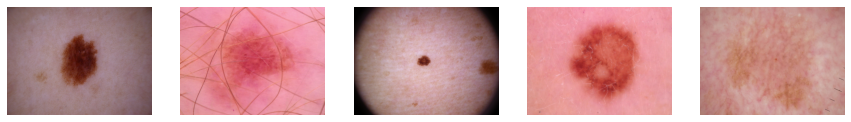

Shifted NV - 671
/content/test/df/


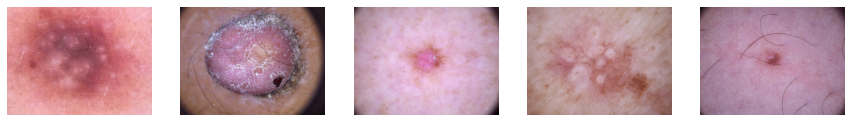

Shifted DF - 12


In [21]:
def move_labels(df, path_dest):
    for label in labels:
        path_folder = path_dest + '/'+ label + '/'
        if os.path.isdir(path_folder):
            continue
        print(path_folder)
        os.mkdir(path_folder)
        label_images = df[df['dx']==label]['image_id']
        for img in label_images:
            shutil.copyfile(f'{path_data}/{img}.jpg',
                            f'{path_dest}/{label}/{img}.jpg')
        show_label(label_images, label, f'{path_dest}/{label}/')
        print(f'Shifted {label.upper()} - {len(label_images)}')
print('Moving Train Images')
move_labels(df_train, path_root + 'train')
print('Moving Test Images')
move_labels(df_val, path_root + 'test')

In [22]:
!gdown --id 19w97EckRyxAGl-bZU0vvQjTYjjYmzIxa

Downloading...
From: https://drive.google.com/uc?id=19w97EckRyxAGl-bZU0vvQjTYjjYmzIxa
To: /content/model.h5
28.2MB [00:00, 89.7MB/s]


In [23]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
import shutil

In [24]:
import tensorflow as tf
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [25]:
datagen_train = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        # brightness_range=(0.9,1.1),
        fill_mode='nearest',
        preprocessing_function= keras.applications.mobilenet.preprocess_input)

datagen_test = ImageDataGenerator(preprocessing_function= keras.applications.mobilenet.preprocess_input)

In [26]:
num_train_samples = 9013
num_test_samples = 1002
train_batch_size = 10
test_batch_size = 10
image_shape = (224, 224)

In [27]:
train_steps = np.ceil(num_train_samples / train_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [28]:
batches_train = datagen_train.flow_from_directory(path_train,
                                                  target_size=image_shape,
                                                  batch_size=train_batch_size)

batches_test = datagen_test.flow_from_directory(path_test,
                                                target_size=image_shape,
                                                batch_size=test_batch_size)

Found 9013 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


# Models

In [29]:
base = tf.keras.applications.mobilenet.MobileNet()
# base.summary()

17227776/17225924 [==============================] - 1s 0us/step


In [30]:
n_labels = len(labels)

In [31]:
x = base.layers[-6].output
x = Dropout(0.25)(x)
outputs = Dense(n_labels, activation='softmax')(x)

In [32]:
model = Model(inputs=base.input, outputs=outputs)

In [33]:
for layers in model.layers[:-23]:
    layers.trainable = False

In [50]:
class_weights={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.0, 6: 1.0}

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 5: 1.0, 6: 1.0}

In [35]:
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

filepath = "model.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks = [checkpoint, reduce_lr]


In [36]:
model.load_weights('/content/model.h5')

In [37]:
history = model.fit(batches_train,
                    steps_per_epoch=train_steps,
                    class_weight=class_weights,
                    validation_data=batches_test,
                    validation_steps=test_steps,
                    epochs=10,
                    shuffle=True,#
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
902/902 [==============================] - 197s 210ms/step - loss: 0.9248 - categorical_accuracy: 0.7435 - top_2_accuracy: 0.9015 - top_3_accuracy: 0.9609 - val_loss: 1.2915 - val_categorical_accuracy: 0.6547 - val_top_2_accuracy: 0.8363 - val_top_3_accuracy: 0.9192

Epoch 00001: val_top_3_accuracy improved from -inf to 0.91916, saving model to model.h5
Epoch 2/10
902/902 [==============================] - 179s 198ms/step - loss: 0.9191 - categorical_accuracy: 0.7495 - top_2_accuracy: 0.9018 - top_3_accuracy: 0.9585 - val_loss: 4.0430 - val_categorical_accuracy: 0.6756 - val_top_2_accuracy: 0.7645 - val_top_3_accuracy: 0.8303

Epoch 00002: val_top_3_accuracy did not improve from 0.91916
Epoch 3/10
902/902 [==============================] - 170s 189ms/step - loss: 0.8627 - categorical_accuracy: 0.7562 - top_2_accuracy: 0.9054 - top_3_accuracy: 0.9614 - val_loss: 1.0438 - val_categorical_accuracy: 0.6427 - val_top_2_accuracy: 0.8733 - val_top_3_accuracy: 0.9391

Epoch 00003: v

In [38]:
!cp /content/model.h5 /content/drive/MyDrive/Files/

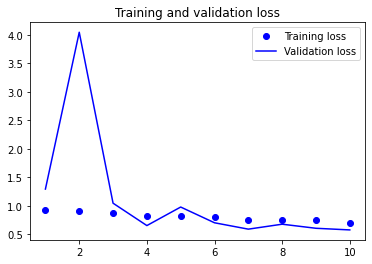

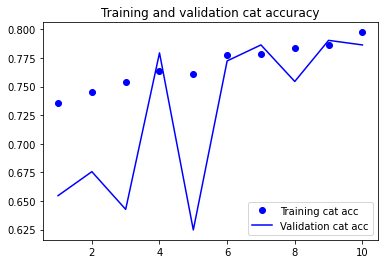

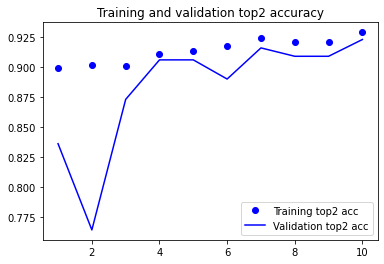

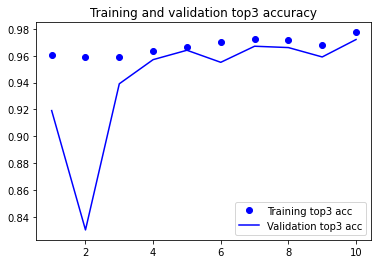

In [39]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [43]:
%mkdir -p sample

In [ ]:
#downloading sample data


def move_labels_k(df, path_dest):
    for label in labels:
        path_folder = path_dest + '/'+ label + '/'
        if os.path.isdir(path_folder):
            continue
        print(path_folder)
        os.mkdir(path_folder)
        label_images = df[df['dx']==label]['image_id']
        for img in label_images[:5]:
            shutil.copyfile(f'{path_data}/{img}.jpg',
                            f'{path_dest}/{label}/{img}.jpg')

move_labels_k(df_val, 'sample')


In [ ]:
!zip -r /content/images.zip /content/sample/

In [49]:
from google.colab import files
files.download('images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>